In [2]:
# Basic imports and loading image
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

ct_path = "D:\\QTFE_local\\Python\\ElectrodesLocalization\\sub11\\in\\CT.nii.gz"
ct = nib.load(ct_path).get_fdata()

### GUI

In [3]:
# GUI to store selected ends of electrodes in the variable 'selected'

from numpy import abs
import cv2
from copy import deepcopy

def preprocess_image():
    img = ct[:,:,:]
    img = (img - img.min()) / (img.max() - img.min())
    img = img.astype(np.float32)
    img = cv2.Mat(img)
    return deepcopy(img)

R = 1    # radius of pixel selection
selected = []
keepGoing = True

k = ct.shape[2]//2    # current height (= slice id in axial plane)

def _isNeighborSelected(i, j, k):
    for a, b, c in selected:
        if abs(i-a) <= 2*R and (j-b) <= 2*R and (k-c) <= 2*R:
            return True
    return False

def _getNeighbors(i, j, k):
    imin, imax = max(0, i-R), min(imgOrig.shape[0], i+R+1)
    jmin, jmax = max(0, j-R), min(imgOrig.shape[1], j+R+1)
    kmin, kmax = max(0, k-R), min(imgOrig.shape[2], k+R+1)
    return imin, imax, jmin, jmax, kmin, kmax
    
def update(i, j, k, add=True):
    if add:
        if not _isNeighborSelected(i, j, k):
            selected.append((i, j, k))
        return
    else:
        if len(selected) > 0:
            selected.pop()

# function to display the coordinates of 
# of the points clicked on the image  
def click_event(event, j, i, flags, params): 
    global k
    if event == cv2.EVENT_LBUTTONDOWN: 
        update(i, j, k, add=True)
    elif event == cv2.EVENT_RBUTTONDOWN:
        update(i, j, k, add=False)
    elif event == cv2.EVENT_MOUSEWHEEL and flags & cv2.EVENT_FLAG_CTRLKEY:
        k = min(k+1, ct.shape[2]-1)
    elif event == cv2.EVENT_MOUSEWHEEL:
        k = max(k-1, 0)
    elif flags & cv2.EVENT_FLAG_ALTKEY:
        global keepGoing
        keepGoing = False

imgOrig = preprocess_image()
img = preprocess_image()

while keepGoing:
    flat_rgb = cv2.cvtColor(img[:,:,k], cv2.COLOR_GRAY2RGB)
    for si, sj, sk in selected:
        if abs(k-sk) <= 2*R:
            imin, imax, jmin, jmax, _, _ = _getNeighbors(si, sj, sk)
            flat_rgb[imin:imax, jmin:jmax] = (0,0,1)    # neighbor pixels become red
    cv2.imshow('image', flat_rgb)
    cv2.setMouseCallback('image', click_event) 
    cv2.waitKey(10) 
cv2.destroyAllWindows() 

KeyboardInterrupt: 

In [5]:
selected

[(370, 187, 167),
 (361, 186, 165),
 (355, 186, 163),
 (347, 185, 161),
 (340, 185, 160),
 (332, 182, 159),
 (326, 183, 157),
 (319, 183, 156),
 (311, 182, 154),
 (303, 181, 153),
 (296, 181, 151),
 (288, 180, 150),
 (281, 179, 149),
 (275, 179, 148),
 (267, 179, 146),
 (260, 179, 145),
 (252, 177, 143)]

In [4]:
# Kill switch
cv2.destroyAllWindows()

In [ ]:
# Create mask that only accepts pixels close to the shafts (based on shafts' ends)

from numpy import cross
from numpy.linalg import norm

threshold = 30

def all_in_tube(x1, x2):
    X, Y, Z = np.indices(img.shape)
    # Shape: (S, C, A, 3)   where S = nb of frames in sagittal plane, ...
    Coords_minus_x1 = np.stack([X-x1[0], Y-x1[1], Z-x1[2]], axis=-1)
    Coords_minus_x2 = np.stack([X-x2[0], Y-x2[1], Z-x2[2]], axis=-1)
    # Formula from: https://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html
    # Shape: (S, C, A)
    Dist_from_line = norm(cross(Coords_minus_x1, Coords_minus_x2, axis=-1), axis=-1) / norm(x2-x1)

    return Dist_from_line < 30

# Shape: (S, C, A)
Accepted = np.zeros(img.shape, dtype=bool)
while len(selected) >= 2:
    x1 = np.array(selected.pop())
    x2 = np.array(selected.pop())
    Accepted = Accepted | all_in_tube(x1, x2)

### Histogram threshold

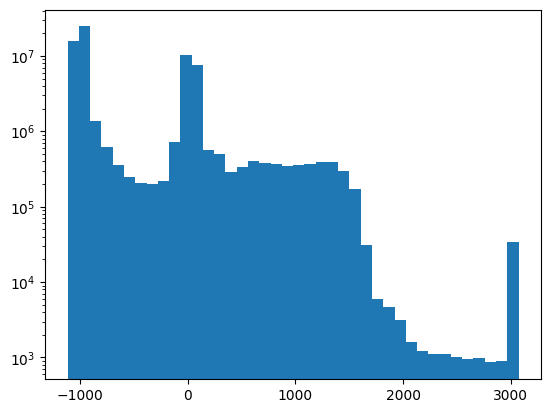

In [ ]:
# Hard threshold based on:
# https://radiopaedia.org/articles/hounsfield-unit

thresh = ct > 2800
ct_thresh = ct[thresh]
plt.hist(ct.ravel(), bins=40, log=True)

binary_img = thresh.astype(dtype=np.int8)


d:\QTFE_local\Python\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


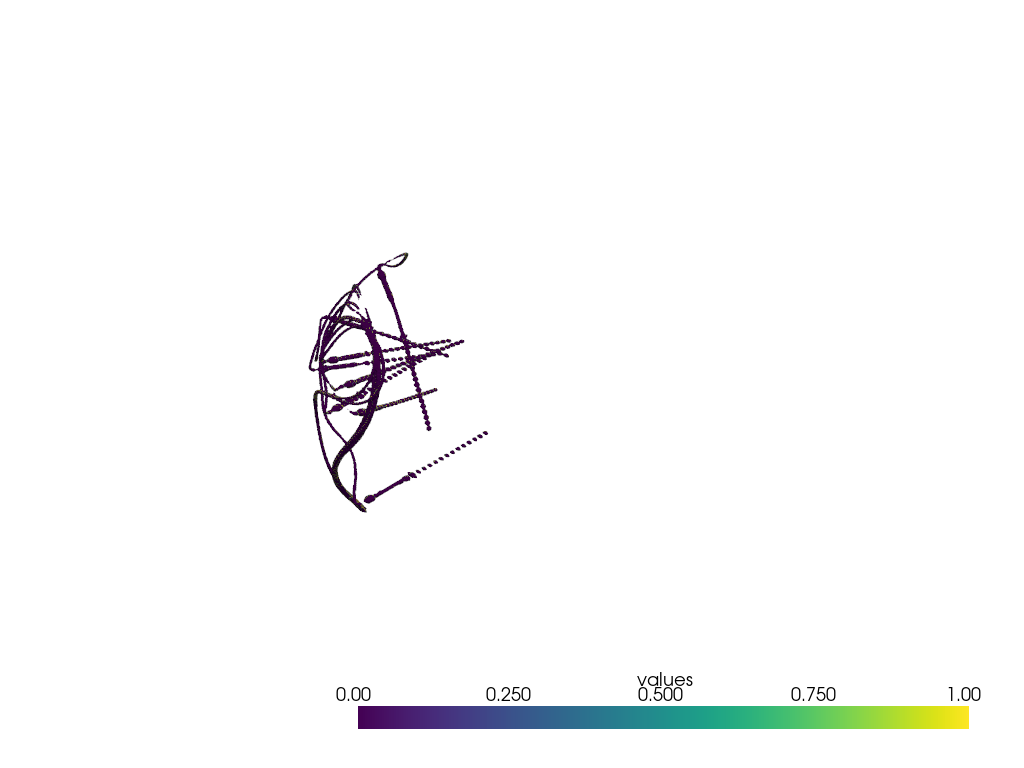

In [16]:
# Visualising results in 3D

import pyvista as pv

def Visualize3D(image:np.array):

    grid = pv.ImageData()

    grid.dimensions = np.array(image.shape) + 1
    grid.cell_data['values'] = image.flatten(order='F')
    plotter = pv.Plotter()
    plotter.add_volume(grid, cmap="gray", opacity=[0,0.045])

    from matplotlib.colors import LinearSegmentedColormap ######################
    from matplotlib import cm

    background='white'
    color_map='Reds'
    voxel=False    # False = smooth display

    datapv = pv.wrap(image)
    datapv.cell_data['labels'] = image[:-1, :-1, :-1].flatten(order='F')

    vol = datapv.threshold(value=1, scalars='labels')
    mesh = vol.extract_surface()
    smooth = mesh.smooth_taubin(n_iter=12)       # smoothing the rendering

    if voxel:
        #vol.plot(cmap=color_map, background=background,
        #            scalars='labels')
        plotter.add_mesh(vol)
    else:
        #smooth.plot(cmap=color_map, background=background,
        #            scalars='labels')
        plotter.add_mesh(smooth)

    plotter.show()


Visualize3D(binary_img)